# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from focal_loss.focal_loss import FocalLoss

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Optimizer

In [6]:
def train_batch(model, image, target,type):
    if(type=="cross"):
        output = model(image)
        loss = criterion(output,target)
    elif(type=="facol0.5"):
        output = model(image)
        output = F.softmax(output,dim=1)
        loss = criterion(output,target)
    elif(type=="facol2"):
        output = model(image)
        output = F.softmax(output,dim=1) # 用于facolloss，和L1Loss
        loss = criterion(output,target)
    elif(type=="L1"):
        output = model(image)
        output = F.softmax(output,dim=1) # 用于facolloss，和L1Loss
        target=torch.nn.functional.one_hot(torch.tensor(target), NUM_CLASS) #用于L1Loss
        loss = criterion(output,target)

    return output, loss

In [7]:

def test_batch(model, image, target,type):
    if(type=="cross"):
        output = model(image)
        loss = criterion(output,target)
    elif(type=="facol0.5"):
        output = model(image)
        output = F.softmax(output,dim=1)
        loss = criterion(output,target)
    elif(type=="facol2"):
        output = model(image)
        output = F.softmax(output,dim=1) # 用于facolloss，和L1Loss
        loss = criterion(output,target)
    elif(type=="L1"):
        output = model(image)
        output = F.softmax(output,dim=1) # 用于facolloss，和L1Loss
        target=torch.nn.functional.one_hot(torch.tensor(target), NUM_CLASS) #用于L1Loss
        loss = criterion(output,target)


    return output, loss

### Model Training

In [12]:
train_loss={}
train_acc={}
test_loss={}
test_acc={}

modelname=["cross","facol0.5","facol2","L1"]
for a in modelname:
    model = ConvNet()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
    if(a=="cross"):
         criterion = nn.CrossEntropyLoss()
    elif(a=="facol0.5"):
         criterion = FocalLoss(gamma=0.5)
    elif(a=="facol2"):
         criterion = FocalLoss(gamma=2)
    elif(a=="L1"):
         criterion = nn.L1Loss()
   
    training_loss = []  # 用于存储训练损失
    training_acc = []   # 用于存储训练精度
    testing_loss = []   # 用于存储测试损失
    testing_acc = []    # 用于存储测试精度

    for epoch in tqdm(range(NUM_EPOCHS), desc="Loading"):
        model.train()  # 设置模型为训练模式
        torch.cuda.empty_cache()  # 清空GPU缓存

    ##########################
    ### Training
    ##########################

        running_cls_loss = 0.0  # 用于累积训练损失
        running_cls_corrects = 0  # 用于累积正确分类的样本数

        for batch_idx, (image, target) in enumerate(train_dataloader):
            image = image.to(device)
            target = target.to(device)

        # 训练模型
            outputs, loss = train_batch(model, image, target,a)
            _, preds = torch.max(outputs, 1) #返回的是(max_values, max_indices)，一般不对indices去梯度

            loss_data = loss.data.item() #可能包含梯度，所以提取纯数据
        
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_dataloader)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        training_loss.append(epoch_loss)  # 记录训练损失
        training_acc.append(epoch_acc.cpu().detach().numpy())  # 记录训练精度

    # 调整学习率
        scheduler.step()

    ##########################
    ### Testing
    ##########################

        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            model.eval()  # 设置模型为评估模式

            val_loss = 0.0  # 用于累积测试损失
            val_corrects = 0  # 用于累积正确分类的样本数

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

            # 测试模型
                outputs, loss = test_batch(model, image, target,a)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)

            testing_loss.append(val_loss)  # 记录测试损失
            testing_acc.append(val_acc.cpu().detach().numpy())  # 记录测试精度

        # 在最后一个周期保存模型
            if (epoch + 1) == NUM_EPOCHS:
                state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc,
                'epoch': (epoch + 1),
                }

            # 检查保存目录是否存在
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

            # 保存模型状态
                torch.save(state, osp.join(SAVE_DIR, a))
                
    
    train_loss[a]=training_loss
    train_acc[a]=training_acc
    test_loss[a]=testing_loss
    test_acc[a]=testing_acc
                


Loading:   0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_112892/2609184041.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target=torch.nn.functional.one_hot(torch.tensor(target), NUM_CLASS) #用于L1Loss
Loading: 100%|██████████| 30/30 [03:50<00:00,  7.68s/it]


In [90]:
len(test_dataloader)

79

In [82]:
def plot_dict(dict_,length):
    for m in dict_:
        if(m=="facol2"):
            plt.plot(range(1,(length+1)),dict_[m],label=m,color="black")
            plt.legend()
        elif(m=="L1"):
            plt.plot(range(1,(length+1)),dict_[m],label=m,color="orange")
            plt.legend()
        else:
            plt.plot(range(1,(length+1)),dict_[m],label=m)
            plt.legend()
    
    return True


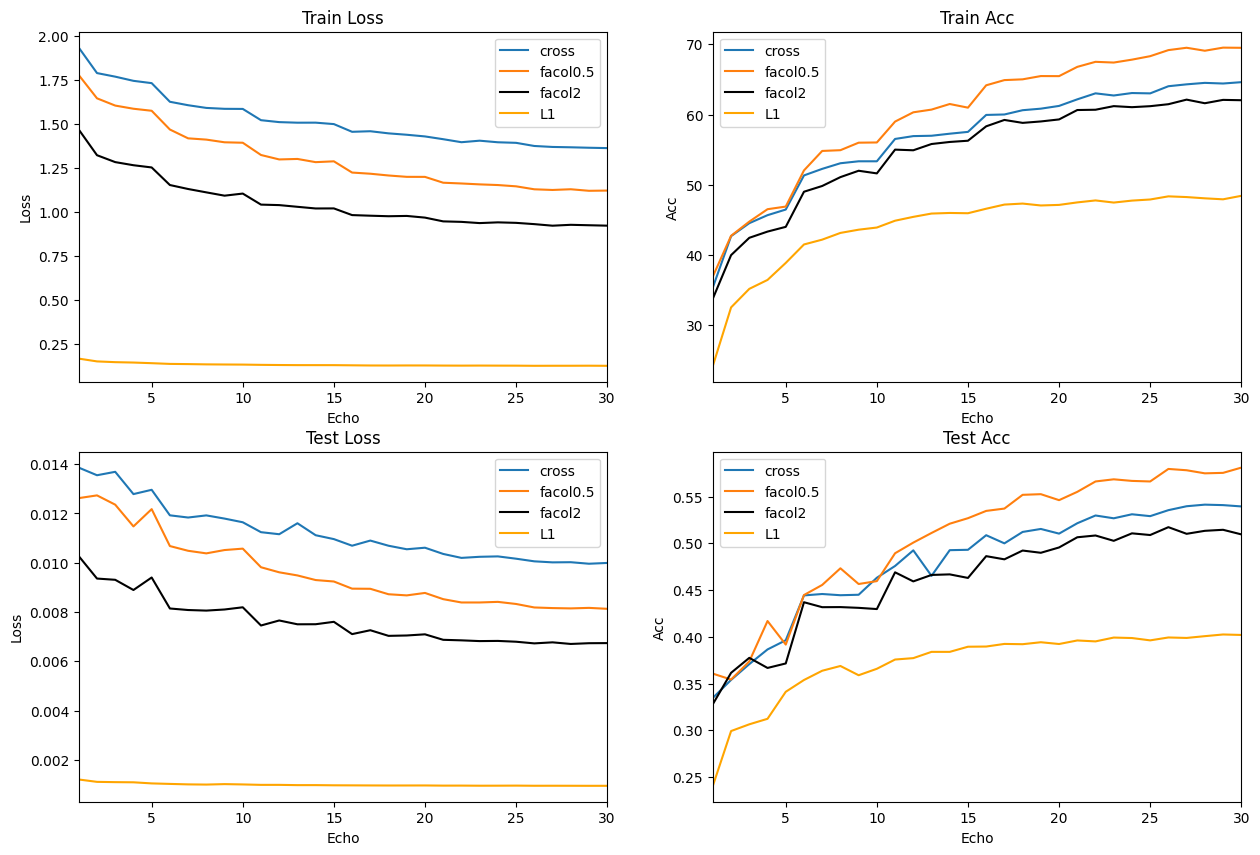

In [88]:
fig=plt.figure(figsize=(15,10))

ax1=plt.subplot(2,2,1)
plot_dict(train_loss,len(train_loss["cross"]))
plt.xlim(1,30)
plt.xlabel("Echo")
plt.ylabel("Loss")
plt.title("Train Loss")

ax2=plt.subplot(2,2,2)
plot_dict(train_acc,len(train_acc["cross"]))
plt.xlim(1,30)
plt.xlabel("Echo")
plt.ylabel("Acc")
plt.title("Train Acc")

ax3=plt.subplot(2,2,3)
plot_dict(test_loss,len(test_loss["cross"]))
plt.xlim(1,30)
plt.xlabel("Echo")
plt.ylabel("Loss")
plt.title("Test Loss")

ax4=plt.subplot(2,2,4)
plot_dict(test_acc,len(test_acc["cross"]))
plt.xlim(1,30)
plt.xlabel("Echo")
plt.ylabel("Acc")
plt.title("Test Acc")


plt.savefig('sample_plot.png')  
plt.show()


### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [18]:
checkpoint = torch.load('./log/L1')  # 替换为实际的模型文件路径

# 将加载的状态字典加载到新模型中
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [24]:
inputs, classes = next(iter(test_dataloader))
input = inputs[1].to(device)
print(input[0])

tensor([[ 2.1264,  2.0489,  2.0682,  ...,  2.0876,  2.0876,  2.0682],
        [ 2.1845,  2.1264,  2.1264,  ...,  2.1458,  2.1458,  2.1264],
        [ 2.1652,  2.1070,  2.1070,  ...,  2.1264,  2.1264,  2.1070],
        ...,
        [-0.7426, -1.5955, -2.0608,  ...,  0.8470,  1.0990,  1.2153],
        [-0.8395, -1.5374, -1.7312,  ...,  0.9439,  1.1571,  1.1959],
        [-0.7813, -1.2272, -1.3047,  ...,  0.8276,  1.0602,  1.1765]],
       device='cuda:0')


In [25]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################

probabilities = F.softmax(model(input),dim=1).cpu().detach().numpy() # 1x10就是，1一维，10就是二维。，归一化
predict_label = np.argmax(probabilities)
print(probabilities)
print(predict_label)

[[5.4673632e-16 9.9907517e-01 1.6600536e-21 8.9227681e-26 6.8841456e-28
  3.3667649e-16 2.4700976e-28 2.5490437e-19 9.2479785e-04 1.7866066e-08]]
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


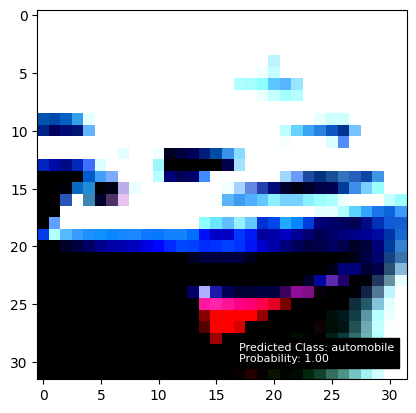

Print probabilities for each class:
airplane: 0.0000
automobile: 0.9991
bird: 0.0000
cat: 0.0000
deer: 0.0000
dog: 0.0000
frog: 0.0000
horse: 0.0000
ship: 0.0009
truck: 0.0000


In [26]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[0,predict_label].item()
image = input.cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0,i].item():.4f}')